In [1]:
import numpy as np 
import pandas as pd 
import os
import scipy.signal as sgn

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple


# from torch import tensor as Tensor


from torch.nn.modules.activation import GELU

import pytorch_lightning as pl
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from util import ProcessSignal

In [2]:
import h5py
import numpy as np
import torch

with h5py.File('datadata.h5','r') as f:
    X_train = np.array(f['X_train'][:])
    y_train = np.array(f['y_train'][:])
    X_test = np.array(f['X_test'][:])
    y_test = np.array(f['y_test'][:])
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))
        


27240 27240
6810 6810


"{'7804ea': 0, '780d8c': 1, '780534': 2, '780b69': 3, '78050f': 4, '780cbc': 5, '78027b': 6, '780fb6': 7, '780fe3': 8, '780291': 9, '7809a3': 10, '780277': 11, '780800': 12, '780831': 13, '7802b1': 14, '7804f5': 15, '780d19': 16, '780dfa': 17, '7805c3': 18, '7804bc': 19, '780063': 20, '780db4': 21, '780c2d': 22, '78027c': 23, '780070': 24, '780df9': 25, '78048b': 26, '780609': 27, '780635': 28, '78048f': 29, '78087a': 30, '780830': 31, '7807cb': 32, '780649': 33}"

In [3]:
class variationalAutoEncoder(pl.LightningModule):
    
    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 lambda_diag: float = 10.,
                 lambda_offdiag: float = 5.,
                 **kwargs) -> None:
        super().__init__()

        self.latent_dim = latent_dim
        self.lambda_diag = lambda_diag
        self.lambda_offdiag = lambda_offdiag

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * 4)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1),
                            nn.Tanh())
    
    def encode(self, input: torch.tensor) -> List[torch.tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]
    
    def decode(self, z: torch.tensor) -> torch.tensor:
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        # print(result.shape)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result
    
    def reparameterize(self, mu: torch.tensor, logvar: torch.tensor) -> torch.tensor:
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def forward(self, input: torch.tensor, **kwargs) -> List[torch.tensor]:
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  self.decode(z)
        
    def training_step(self, batch, batch_idx):
        x, y = batch['x'], batch['y']
        mu ,log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_hat = self.decode(z)
        # DIP Loss
        # centered_mu = mu - mu.mean(dim=1, keepdim = True) # [B x D]
        # cov_mu = centered_mu.t().matmul(centered_mu).squeeze() # [D X D]

        # Add Variance for DIP Loss II
        # cov_z = cov_mu + torch.mean(torch.diagonal((2. * log_var).exp(), dim1 = 0), dim = 0) # [D x D]
        # For DIp Loss I
        # cov_z = cov_mu

        # cov_diag = torch.diag(cov_z) # [D]
        # cov_offdiag = cov_z - torch.diag(cov_diag) # [D x D]
        # dip_loss = self.lambda_offdiag * torch.sum(cov_offdiag ** 2) + \
        #            self.lambda_diag * torch.sum((cov_diag - 1) ** 2)
        loss = F.mse_loss(x_hat, x)+torch.mean(-0.5*torch.sum(1+log_var - mu **2 - log_var.exp(),dim=1),dim=0)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
        

In [4]:
class AE_Dataset:
    def __init__(self, dataset, targets):
        self.dataset = dataset
        self.targets = targets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        return {
            'x': torch.tensor(self.dataset[item],dtype=torch.float32),
            'y': torch.tensor(self.targets[item],dtype=torch.float32)
        }

In [5]:
class AE_DataModule(pl.LightningDataModule):
    def __init__(self, data, targets, BATCH_SIZE, fold = None):
        super().__init__()
        self.BATCH_SIZE = BATCH_SIZE
        self.data = data
        self.targets = targets
        self.fold = fold
        
    def preapre_data(self):
        pass
    
    def setup(self, stage=None):
        pass
         
        
    def train_dataloader(self):
        self.train_dataset = AE_Dataset(dataset = self.data,targets = self.targets)
        
        return torch.utils.data.DataLoader(
            self.train_dataset, batch_size=self.BATCH_SIZE)
    
    def valid_dataloader(self):
        return None
    
    def test_dataloader(self):
        return None

In [24]:
len(data)

34050

In [36]:
train_mode = 1


EPOCHS = 20
GPU = [1]
BATCH_SIZE = 128
# NUM_FEATURES = len(data[0])


# if train_mode:
early_stop_callback = EarlyStopping(
    monitor='train_loss',
    min_delta=0.001, patience=3, verbose=True, mode='min')
DataLoader = AE_DataModule(data=data, targets=target, BATCH_SIZE=BATCH_SIZE)
trainer = pl.Trainer(gpus=GPU, max_epochs=EPOCHS, weights_summary='full')
# callbacks=[early_stop_callback])

AEncoder = variationalAutoEncoder(1,32)

trainer.fit(AEncoder, DataLoader)
torch.save(AEncoder.state_dict(), './encoder1.pkl')
# else:
#     AEncoder = LitAutoEncoder(input_shape=NUM_FEATURES)
#     AEncoder.load_state_dict(torch.load('./encoder.pkl',map_location=torch.device('cpu')))

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

   | Name          | Type            | Params
---------------------------------------------------
0  | encoder       | Sequential      | 1.6 M 
1  | encoder.0     | Sequential      | 384   
2  | encoder.0.0   | Conv2d          | 320   
3  | encoder.0.1   | BatchNorm2d     | 64    
4  | encoder.0.2   | LeakyReLU       | 0     
5  | encoder.1     | Sequential      | 18.6 K
6  | encoder.1.0   | Conv2d          | 18.5 K
7  | encoder.1.1   | BatchNorm2d     | 128   
8  | encoder.1.2   | LeakyReLU       | 0     
9  | encoder.2     | Sequential      | 74.1 K
10 | encoder.2.0   | Conv2d          | 73.9 K
11 | encoder.2.1   | BatchNorm2d     | 256   
12 | encoder.2.2   | LeakyReLU       | 0     
13 | encoder.3     | Sequential      | 295 K 
14 | encoder.3.0   | Conv2d          | 295 K 
15 | encoder.3.1   | BatchNorm2d     | 512   
16 | encoder.3.2   | LeakyReLU       | 0     

Training: |          | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_536599/2234801870.py:137: UserWarning: Using a target size (torch.Size([128, 1, 64, 64])) that is different to the input size (torch.Size([128, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x_hat, x)+torch.mean(-0.5*torch.sum(1+log_var - mu **2 - log_var.exp(),dim=1),dim=0)
/tmp/ipykernel_536599/2234801870.py:137: UserWarning: Using a target size (torch.Size([2, 1, 64, 64])) that is different to the input size (torch.Size([2, 3, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x_hat, x)+torch.mean(-0.5*torch.sum(1+log_var - mu **2 - log_var.exp(),dim=1),dim=0)


In [38]:
vae = variationalAutoEncoder(1,32)
vae.load_state_dict(torch.load('./encoder1.pkl',map_location=torch.device('cuda:0')))

<All keys matched successfully>

In [28]:
mu ,log_var = vae.encode(torch.tensor(data[2].reshape(1,1,64,64),dtype=torch.float32))
z = vae.reparameterize(mu, log_var)
x_hat = vae.decode(z)

In [29]:
x_hat[0,0,:,:].shape

torch.Size([64, 64])

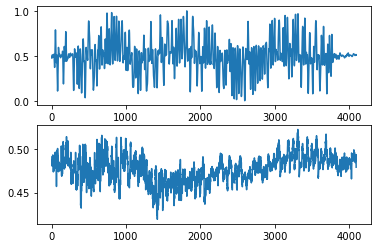

In [30]:
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
a = data[2][0].reshape(1,-1)
plt.plot(a.squeeze())
plt.subplot(2,1,2)
plt.plot(x_hat[0,0,:,:].detach().reshape(1,-1).squeeze())



In [6]:
vae = variationalAutoEncoder(1,32)
vae.load_state_dict(torch.load('./encoder.pkl',map_location=torch.device('cuda:0')))
vae.eval()
newdata = []
for i in range(len(X_train)):
    mu ,log_var = vae.encode(torch.tensor(X_train[i].reshape(1,1,64,64),dtype=torch.float32))
    z = vae.reparameterize(mu, log_var)
    x_hat = vae.decode(z)
    newdata.append(x_hat[0,0,:,:].detach().numpy().reshape(1,-1).squeeze())


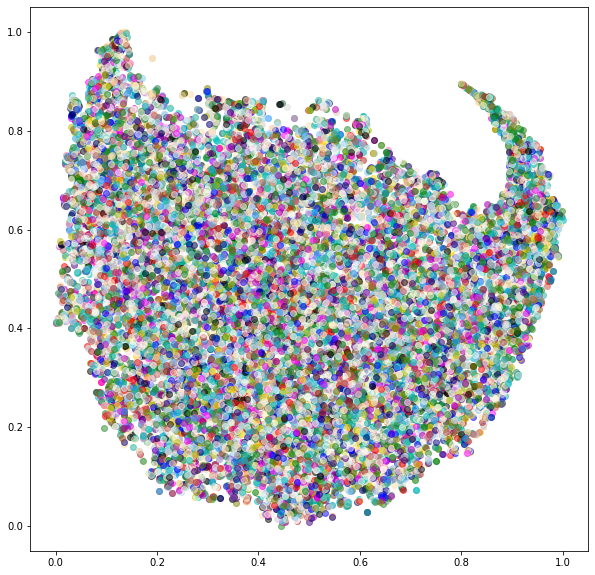

In [7]:
import Tsne

Tsne.DecAndPlot(newdata,y_train)